# **Train Price Prediction System**
This notebook focuses on building a machine learning model for predicting train ticket prices based on various features of train journeys. The dataset used contains information about train routes, dates, types, and classes of trains, along with the corresponding ticket prices.

**Dataset Overview:**

The dataset includes the following columns:

- insert_date: The timestamp when the data was recorded.
- origin: The starting location of the train.
- destination: The destination location of the train.
- start_date: The date and time when the train journey begins.
- end_date: The date and time when the train journey ends.
- train_type: The type of train service (e.g., MD-AVE, ALVIA).
- price: The ticket price for the specific journey.
- train_class: The class of service (e.g., Turista, Turista con enlace).
- fare: The fare type (e.g., Flexible, Promo +).

**Objective:**

The goal of this project is to predict the train ticket price using features such as the origin, destination, train type, train class, and journey dates. By doing so, we aim to provide valuable insights into ticket pricing patterns and help optimize fare strategies for travelers and train service providers.

**Approach:**

We will clean and preprocess the data, explore it to understand key patterns and trends, and then build a machine learning model to predict ticket prices. This model will be evaluated using appropriate metrics to ensure its effectiveness in making accurate predictions.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
from flask import Flask, request, jsonify

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# df = pd.read_csv("/content/drive/MyDrive/projects/Train_Price_Prediction/Train.csv")

In [3]:
df = pd.read_csv("Train.csv")

In [4]:
df.head()

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,702,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 15:00:00,2019-06-02 19:42:00,MD-AVE,59.50,Turista con enlace,Flexible
1,703,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:03:00,MD-AVE,34.65,Turista con enlace,Promo +
2,704,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:10:00,MD-LD,39.95,Turista con enlace,Promo +
3,705,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 22:14:00,MD-AVE,40.60,Turista con enlace,Promo +
4,706,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 18:55:00,2019-06-02 23:03:00,ALVIA,27.90,Turista,Promo


## **Data Cleaning**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215909 entries, 0 to 215908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   215909 non-null  int64  
 1   insert_date  215909 non-null  object 
 2   origin       215909 non-null  object 
 3   destination  215909 non-null  object 
 4   start_date   215909 non-null  object 
 5   end_date     215909 non-null  object 
 6   train_type   215909 non-null  object 
 7   price        202321 non-null  float64
 8   train_class  215266 non-null  object 
 9   fare         215266 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 16.5+ MB


In [6]:
df.shape

(215909, 10)

In [7]:
(df.isnull().sum()/df.shape[0])*100

Unnamed: 0     0.000000
insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          6.293392
train_class    0.297811
fare           0.297811
dtype: float64

As null values are around 5-6 percent of the whole dataset so i will drop them.


In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().sum()

Unnamed: 0     0
insert_date    0
origin         0
destination    0
start_date     0
end_date       0
train_type     0
price          0
train_class    0
fare           0
dtype: int64

In [10]:
df.columns

Index(['Unnamed: 0', 'insert_date', 'origin', 'destination', 'start_date',
       'end_date', 'train_type', 'price', 'train_class', 'fare'],
      dtype='object')

In [11]:
col = ['origin', 'destination','train_type', 'price', 'train_class', 'fare']
for i in col:
    print(f"Unique values in {i} column are:")
    print(df[i].unique())
    print("*"*100)
    print()

Unique values in origin column are:
['PONFERRADA' 'MADRID' 'SEVILLA' 'VALENCIA' 'BARCELONA']
****************************************************************************************************

Unique values in destination column are:
['MADRID' 'VALENCIA' 'BARCELONA' 'PONFERRADA' 'SEVILLA']
****************************************************************************************************

Unique values in train_type column are:
['MD-AVE' 'MD-LD' 'ALVIA' 'REGIONAL' 'AVE' 'INTERCITY' 'AVE-MD' 'AVE-LD'
 'R. EXPRES' 'AVE-TGV' 'AV City' 'MD' 'LD' 'LD-MD' 'TRENHOTEL']
****************************************************************************************************

Unique values in price column are:
[ 59.5   34.65  39.95  40.6   27.9   28.35  21.95  39.45  29.9   33.65
  45.3   71.    56.1   66.55  30.9   51.15  36.15  27.8   43.25  66.75
  85.1  107.7  102.15  90.5   88.95  98.   100.4   98.55  75.4   58.15
  80.15  69.8   58.95  52.5   69.4   76.3   79.65 128.5   62.2   64.05
  72.3 

#### Explanation of Unique Values in the Dataset:

**Origin and Destination:**

These columns represent the starting and ending points of the train journey. The unique values indicate popular train stations in Spain.
- PONFERRADA: A town in the province of León.
-MADRID: The capital city of Spain and a major hub for train travel.
-SEVILLA: A city in the Andalusia region, known for its cultural and historical significance.
-VALENCIA: A port city on Spain's southeastern coast.
-BARCELONA: A major city and popular tourist destination in Catalonia.

**Train Type:**

This column indicates the type of train or service. Each train type has its own characteristics, such as speed, comfort, and route:
- MD-AVE: A medium-distance train that runs on the AVE high-speed network.
- MD-LD: A medium-distance train on long-distance routes.
- ALVIA: A high-speed service that can run on both high-speed and conventional tracks.
- REGIONAL: Trains that operate on shorter, regional routes.
- AVE: The high-speed rail service, known for its fast travel times.
- INTERCITY: A long-distance train that connects major cities.
- AVE-MD: A combination of AVE and medium-distance service.
- AVE-LD: A combination of AVE and long-distance service.
- R. EXPRES: A regional express service.
- AVE-TGV: High-speed collaboration between Spain's AVE and France's TGV services.
- AV City: A slightly slower version of AVE, with fewer amenities.
- MD: Medium-distance trains.
- LD: Long-distance trains.
- LD-MD: A combination of long-distance and medium-distance services.
- TRENHOTEL: Overnight trains with sleeping accommodations.

**Train Class**:

This column indicates the class of service provided on the train, affecting the level of comfort and amenities.
- Turista con enlace: Standard class with a connection to another service.
- Turista: Standard class, offering basic amenities.
- Preferente: First-class service, offering enhanced comfort and amenities.
- Turista Plus: A premium version of the standard class, offering better seating.
- Cama Turista: A sleeper class for overnight trains, providing beds for passengers.

**Fare:**

This column represents the fare type, which determines the pricing flexibility and potential discounts:
- Flexible: A fare that allows changes and cancellations with minimal restrictions.
- Promo +: A promotional fare with some flexibility but usually offering a discount.
- Promo: A heavily discounted fare with limited flexibility.
- Adulto ida: A standard one-way fare for adults.
- Mesa: A special group fare, often offering discounts for booking a table of seats.

In [12]:
df.head()

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,702,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 15:00:00,2019-06-02 19:42:00,MD-AVE,59.50,Turista con enlace,Flexible
1,703,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:03:00,MD-AVE,34.65,Turista con enlace,Promo +
2,704,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:10:00,MD-LD,39.95,Turista con enlace,Promo +
3,705,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 22:14:00,MD-AVE,40.60,Turista con enlace,Promo +
4,706,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 18:55:00,2019-06-02 23:03:00,ALVIA,27.90,Turista,Promo


In [13]:
# converting them to datetime
df['insert_date'] = pd.to_datetime(df['insert_date'], format = '%Y-%m-%d %H:%M:%S')
df['start_date'] = pd.to_datetime(df['start_date'], format = '%Y-%m-%d %H:%M:%S')
df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d %H:%M:%S')

In [14]:
df["journey_duration_hrs"] = (df['end_date'] - df['start_date']).dt.total_seconds()/3600

In [15]:
df["journey_duration_hrs"] =df["journey_duration_hrs"].apply(lambda x : round(x,2))

In [16]:
df.head()

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,journey_duration_hrs
0,702,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 15:00:00,2019-06-02 19:42:00,MD-AVE,59.50,Turista con enlace,Flexible,4.70
1,703,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:03:00,MD-AVE,34.65,Turista con enlace,Promo +,5.80
2,704,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:10:00,MD-LD,39.95,Turista con enlace,Promo +,5.92
3,705,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 22:14:00,MD-AVE,40.60,Turista con enlace,Promo +,4.98
4,706,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 18:55:00,2019-06-02 23:03:00,ALVIA,27.90,Turista,Promo,4.13


In [17]:
df["booking_before_days"] = (df["start_date"] - df['insert_date']).dt.days

In [18]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [19]:
df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,journey_duration_hrs,booking_before_days
0,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 15:00:00,2019-06-02 19:42:00,MD-AVE,59.50,Turista con enlace,Flexible,4.70,44
1,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:03:00,MD-AVE,34.65,Turista con enlace,Promo +,5.80,44
2,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:10:00,MD-LD,39.95,Turista con enlace,Promo +,5.92,44
3,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 22:14:00,MD-AVE,40.60,Turista con enlace,Promo +,4.98,44
4,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 18:55:00,2019-06-02 23:03:00,ALVIA,27.90,Turista,Promo,4.13,44


# **Data Visualization**

In [20]:
categorical_col = list(df.select_dtypes(include = 'object').columns)
categorical_col

['origin', 'destination', 'train_type', 'train_class', 'fare']

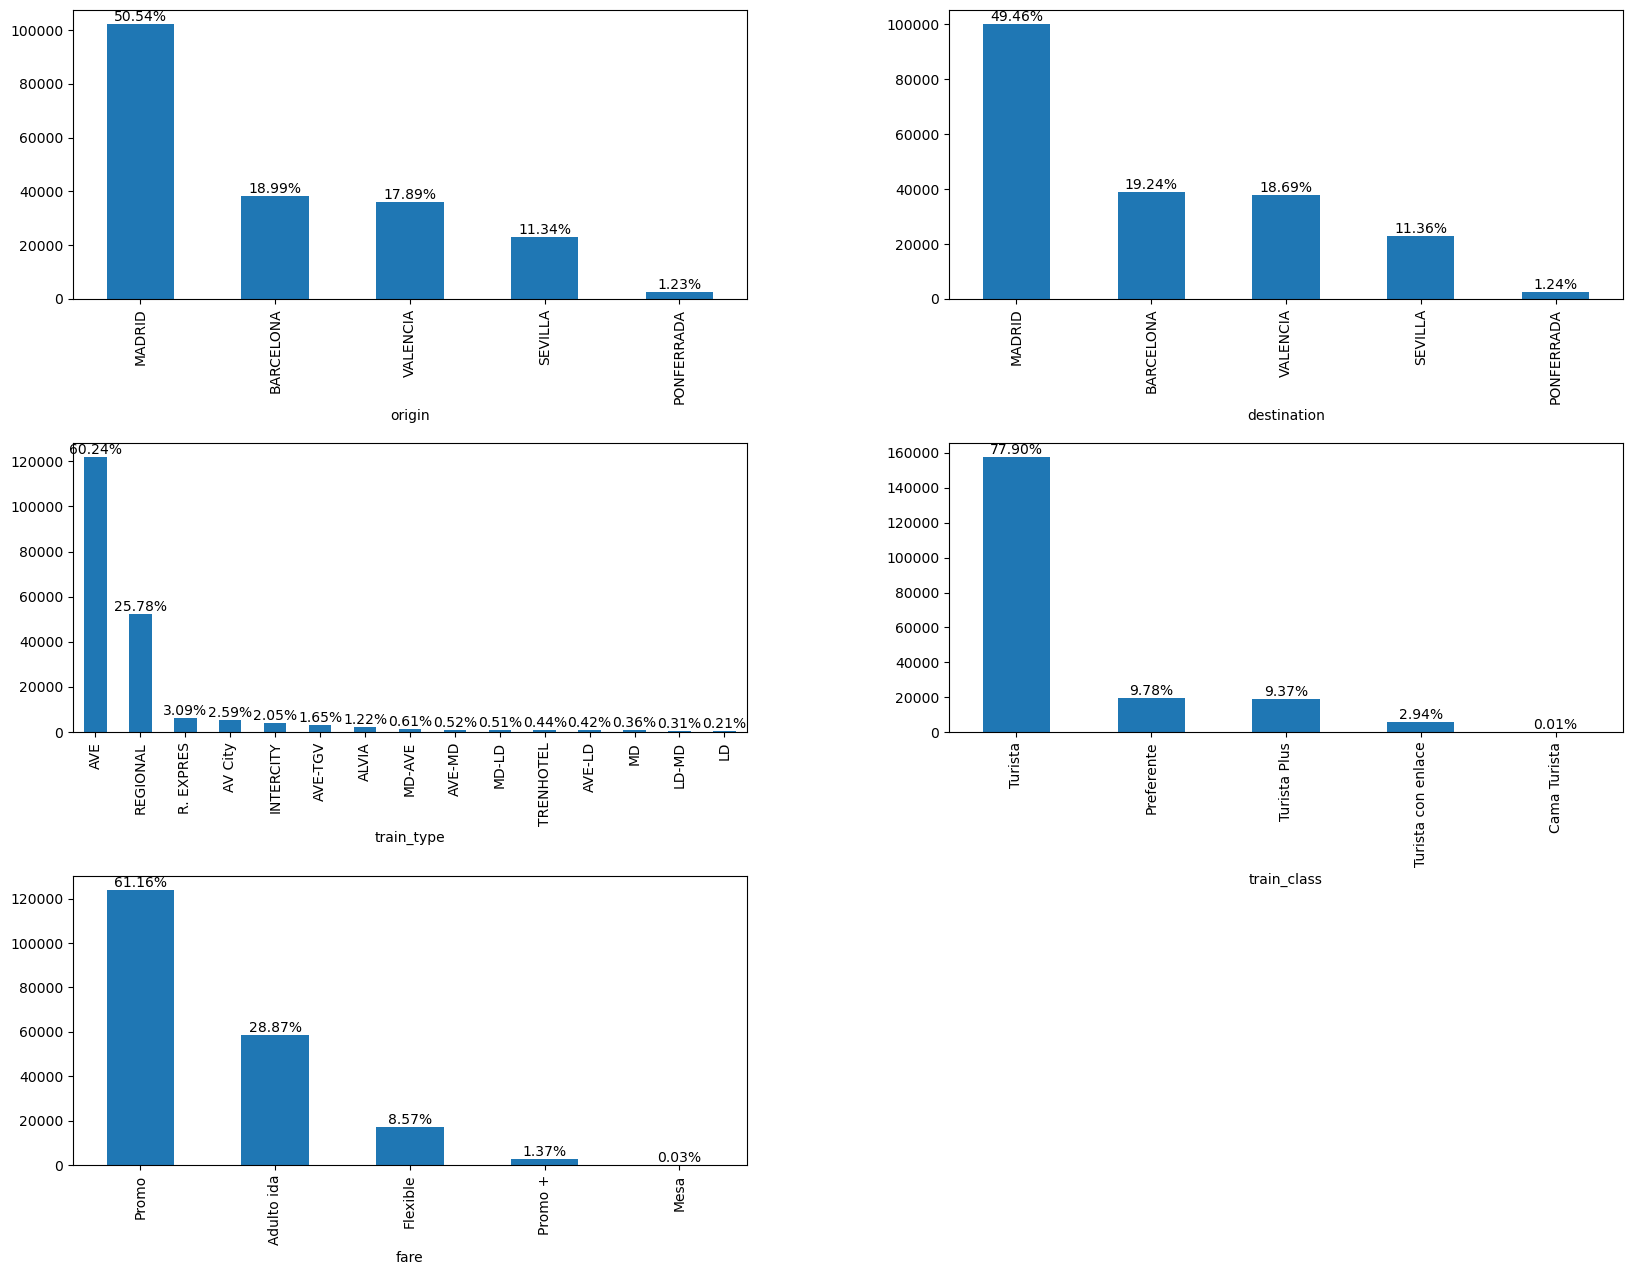

In [21]:
plt.figure(figsize = (20,15))
for i in range(1, len(categorical_col)+1):
    plt.subplot(3,2,i)
    bar = df[categorical_col[i-1]].value_counts().plot(kind= 'bar')

    for container in bar.containers:
        bar.bar_label(container, labels=[f'{(val/df.shape[0])*100:.2f}%' for val in container.datavalues])

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202321 entries, 0 to 215908
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   insert_date           202321 non-null  datetime64[ns]
 1   origin                202321 non-null  object        
 2   destination           202321 non-null  object        
 3   start_date            202321 non-null  datetime64[ns]
 4   end_date              202321 non-null  datetime64[ns]
 5   train_type            202321 non-null  object        
 6   price                 202321 non-null  float64       
 7   train_class           202321 non-null  object        
 8   fare                  202321 non-null  object        
 9   journey_duration_hrs  202321 non-null  float64       
 10  booking_before_days   202321 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(1), object(5)
memory usage: 18.5+ MB


In [23]:
numerical_col = df.select_dtypes(include = ["float64", "int64"]).columns
numerical_col

Index(['price', 'journey_duration_hrs', 'booking_before_days'], dtype='object')

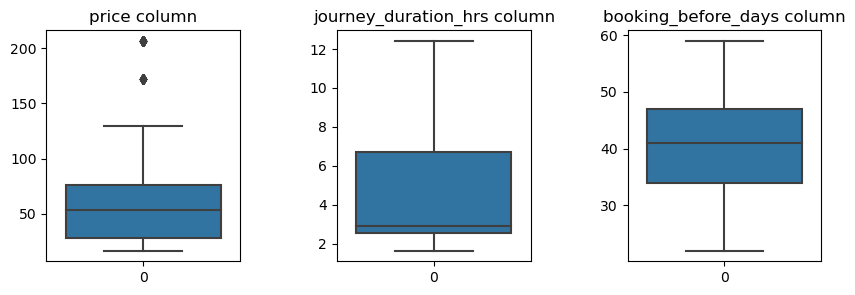

In [24]:
plt.figure(figsize=(10,3))
for i in range(1, len(numerical_col)+1):
    plt.subplot(1,3,i)
    sns.boxplot(df[numerical_col[i-1]])
    plt.title(f"{numerical_col[i-1]} column")
plt.subplots_adjust(hspace= 0.5, wspace=0.5)
plt.show()

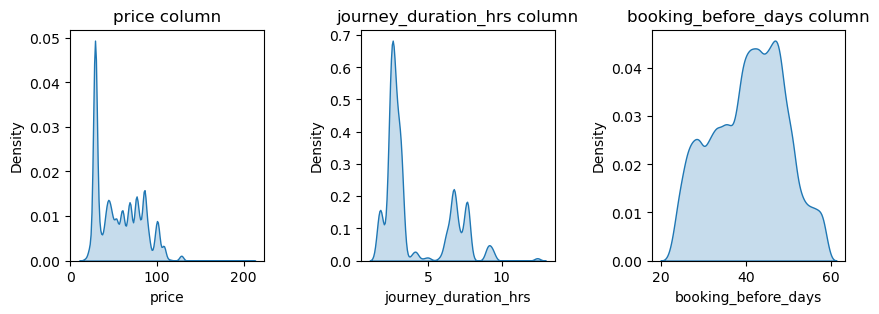

In [25]:
plt.figure(figsize=(10,3))
for i in range(1, len(numerical_col)+1):
    plt.subplot(1,3,i)
    sns.kdeplot(df[numerical_col[i-1]], fill = True)
    plt.title(f"{numerical_col[i-1]} column")

plt.subplots_adjust(hspace= 0.5, wspace=0.5)
plt.show()



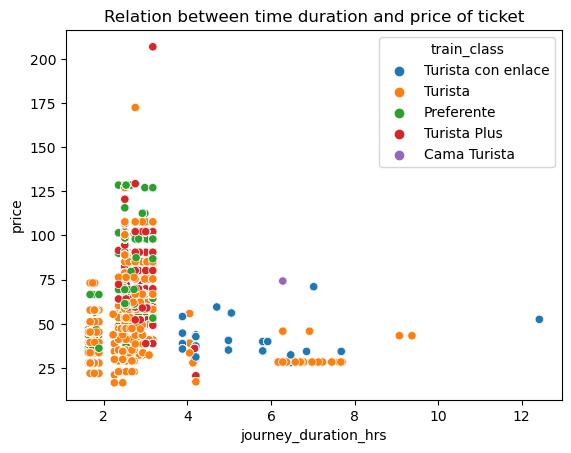

In [26]:
sns.scatterplot(x = 'journey_duration_hrs', y = "price", data = df, hue= 'train_class')
plt.title("Relation between time duration and price of ticket")
plt.show()

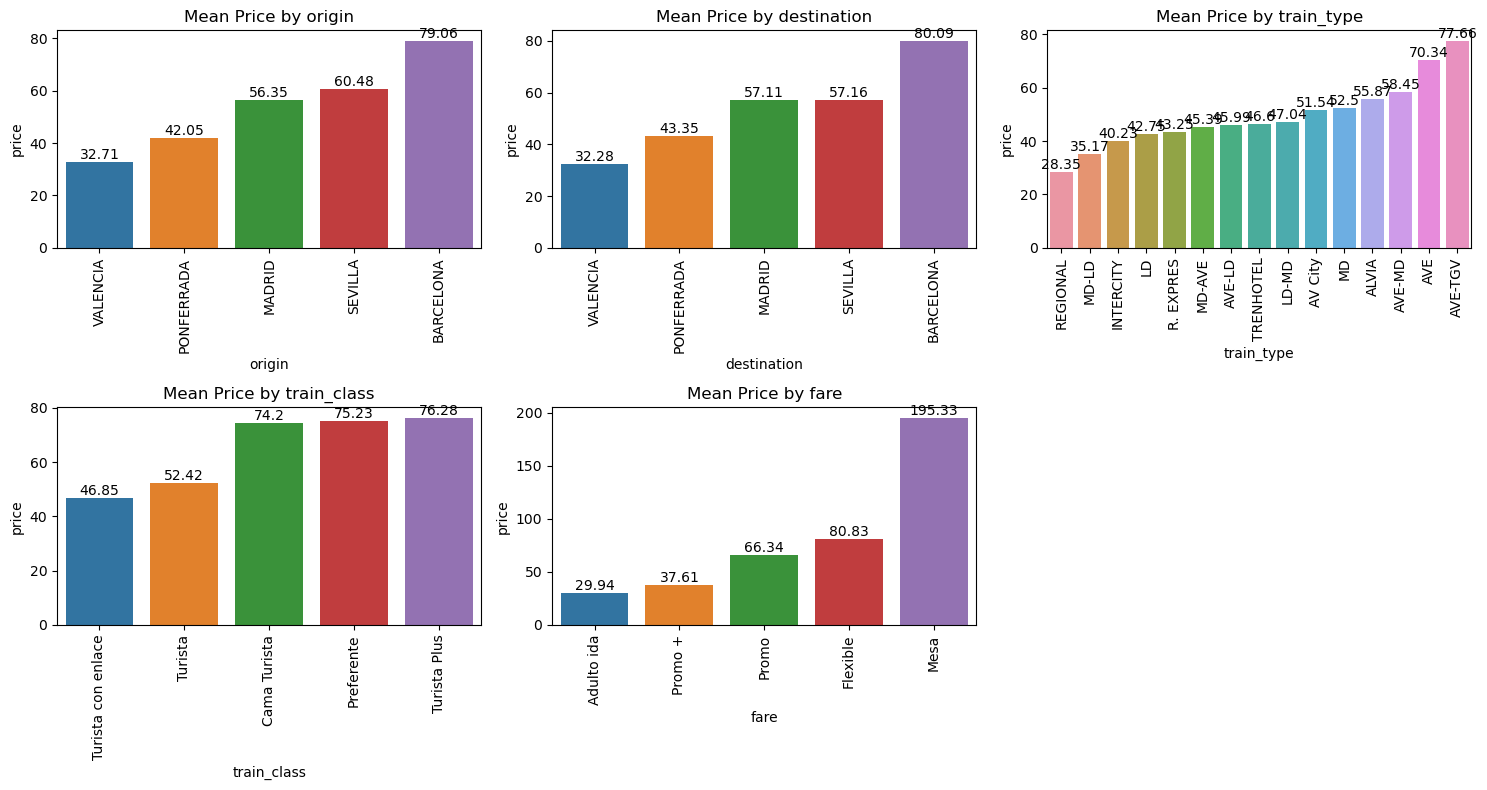

In [27]:

plt.figure(figsize=(15, 8))

for col in range(1, len(categorical_col) + 1):
    plt.subplot(2, 3, col)
    mean_price = df.groupby(categorical_col[col - 1])["price"].mean().sort_values().reset_index()
    mean_price["price"] = mean_price["price"].apply(lambda x: round(x,2))
    bar_plot = sns.barplot(x=categorical_col[col - 1], y='price', data=mean_price)

    for values in bar_plot.containers:
      bar_plot.bar_label(values)

    plt.title(f"Mean Price by {categorical_col[col - 1]}")
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()



In [29]:
numerical_col = df.select_dtypes(include = ["float64", "int64"])
numerical_col.corr()

,price,journey_duration_hrs,booking_before_days
price,1.000000,-0.584693,-0.309446
journey_duration_hrs,-0.584693,1.000000,0.333906
booking_before_days,-0.309446,0.333906,1.000000


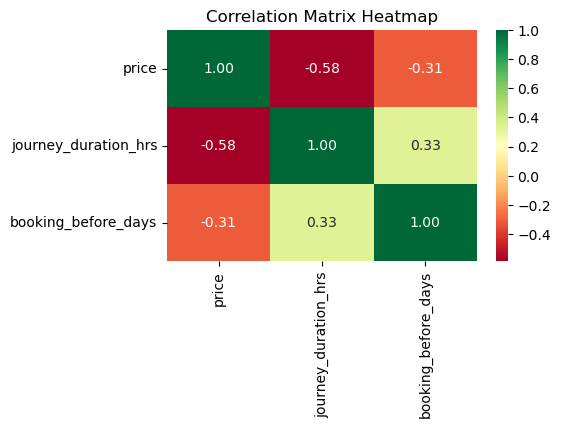

In [30]:
plt.figure(figsize=(5, 3))
sns.heatmap(numerical_col.corr(), cmap="RdYlGn", annot=True, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()



# **Insights and Conclusion:**

- **Origin and Destination:**

The dataset highlights key Spanish cities as train origins and destinations: Ponferrada, Madrid, Sevilla, Valencia, and Barcelona. From the bar graph insights, we observe that:

- Madrid is the most popular destination, with nearly 50% of all trips ending there, confirming its status as a major hub for train travel.
- Ponferrada, on the other hand, sees the least traffic, with only 1% of trips ending there, reflecting its smaller size and less frequent train connections compared to other cities.
- This difference in the volume of passengers traveling to these destinations reflects the economic and tourist significance of cities like Madrid and Barcelona compared to smaller towns like Ponferrada.

**Train Type:**

Different types of train services cater to various routes, speeds, and comfort levels. The dataset includes types like MD-AVE (medium distance, high speed), ALVIA (high speed on both conventional and high-speed tracks), and AVE (high-speed service). According to the bar graph insights:

- AVE is the most preferred train type, with almost 60% of people choosing this high-speed service, indicating a preference for faster travel between major cities.
- LD-AVE is the least preferred, with only 0.17% of passengers opting for this service. This could be because it operates on longer routes and is less efficient for shorter, high-traffic routes.
- This shows that travelers value high-speed and convenience, especially between major hubs like Madrid and Barcelona.

**Train Class:**

Train classes indicate different levels of comfort and amenities. The dataset includes classes like Turista, Preferente (first-class), and Cama Turista (sleeper class). The bar graph insights reveal that:

- Turista class is the most popular, with nearly 75% of travelers opting for this economical and basic service, which is suitable for shorter distances and more budget-conscious travelers.
- Cama Turista, on the other hand, is the least preferred, with only 0.01% opting for this overnight sleeper class. This aligns with the nature of most trips being shorter and not requiring overnight accommodations.
- The choice of train class reflects the nature of the trip; most passengers opt for economical options for shorter journeys, while only a few choose first-class or sleeper options.

**Fare:**

Fare options in the dataset include Flexible (allowing changes), Promo + (discounts with some flexibility), and Mesa (group discounts). The bar graph insights show that:

- Promo fares are by far the most popular, with 61% of passengers choosing discounted fares. This suggests that most passengers prioritize cost savings over flexibility.
- Mesa fares, group fares for booking a table of seats, are the least preferred at only 0.04%. This reflects the individual nature of most bookings, as Mesa fares are better suited to group travel.
- The popularity of promotional fares suggests that price sensitivity is a major factor for train travelers, which is reinforced by the correlation insights showing a negative relationship between price and both booking days in advance and journey duration.

**Box Plot and KDE Plot Insights:**
- Price: The price distribution shows a median around 50, with a few outliers beyond 200. This indicates that while most trips are relatively affordable, some journeys—likely those involving longer distances, first-class services, or last-minute bookings—can be significantly more expensive.

- Journey Duration: The median journey duration is around 3 hours, which fits well with the routes between major cities like Madrid, Barcelona, and Valencia. The longer journeys (up to 12 hours) might be explained by routes involving smaller towns like Ponferrada.

- Booking Lead Time: Most passengers book their tickets 30 to 50 days in advance, showing a preference for early booking, which likely correlates with cheaper, promotional fares.

**Heatmap Insights:**

- Price and Booking Lead Time: The negative correlation between price and booking lead time suggests that prices are lower when booked in advance, especially with Promo fares being the most popular. This is a common pricing strategy in the travel industry to encourage early bookings.
- Price and Journey Duration: The negative correlation here indicates that longer journeys tend to have lower prices, possibly due to lower demand for certain routes or the availability of discounted fares.
- Journey Duration and Booking Lead Time: The positive correlation between journey duration and booking lead time implies that longer journeys are often booked further in advance, potentially reflecting the need for more planning for longer trips.

**Conclusions:**
- Travel Preferences: The majority of passengers prefer traveling to and from major hubs like Madrid and Barcelona using high-speed AVE trains, with a strong preference for the economical Turista class and discounted Promo fares.
- Pricing and Booking Trends: Price is a significant factor for most travelers, as demonstrated by the popularity of discounted fares and the negative correlation between price and both journey duration and booking lead time.Travelers tend to book early to secure lower prices.
- Journey Duration: Most trips are relatively short (around 3 hours), and longer trips (up to 12 hours) are less common but planned well in advance. These longer journeys may explain some of the higher prices seen in the outliers.
- Fare Strategy: The current fare strategy seems effective in incentivizing early bookings through discounts. Promo fares dominate, and passengers are willing to plan ahead to save on costs.
- These insights can help in understanding passenger behavior, optimizing fare structures, and improving services to better meet traveler preferences across Spain’s rail network.

# machine learning

In [31]:
df.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare,journey_duration_hrs,booking_before_days
0,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 15:00:00,2019-06-02 19:42:00,MD-AVE,59.50,Turista con enlace,Flexible,4.70,44
1,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:03:00,MD-AVE,34.65,Turista con enlace,Promo +,5.80,44
2,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 23:10:00,MD-LD,39.95,Turista con enlace,Promo +,5.92,44
3,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 17:15:00,2019-06-02 22:14:00,MD-AVE,40.60,Turista con enlace,Promo +,4.98,44
4,2019-04-19 05:37:35,PONFERRADA,MADRID,2019-06-02 18:55:00,2019-06-02 23:03:00,ALVIA,27.90,Turista,Promo,4.13,44


In [32]:
# removing the columns which are not required
df.drop(columns = ["insert_date", "start_date", "end_date"], inplace = True)

In [ ]:
# saving a copy of cleaned data for machine learning algorithms
# df.to_csv("/content/drive/MyDrive/projects/Train_Price_Prediction/Train_dataset_for_ml.csv")

In [ ]:
# data = pd.read_csv("/content/drive/MyDrive/projects/Train_Price_Prediction/Train_dataset_for_ml.csv")

In [35]:
data = pd.read_csv("Train_dataset_for_ml.csv")

In [36]:
df.to_csv("Train_dataset_for_ml.csv")

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202321 entries, 0 to 202320
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            202321 non-null  int64  
 1   origin                202321 non-null  object 
 2   destination           202321 non-null  object 
 3   train_type            202321 non-null  object 
 4   price                 202321 non-null  float64
 5   train_class           202321 non-null  object 
 6   fare                  202321 non-null  object 
 7   journey_duration_hrs  202321 non-null  float64
 8   booking_before_days   202321 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 13.9+ MB


In [38]:
data.drop(columns = 'Unnamed: 0', inplace = True)

In [39]:
data.head()

,origin,destination,train_type,price,train_class,fare,journey_duration_hrs,booking_before_days
0,PONFERRADA,MADRID,MD-AVE,59.50,Turista con enlace,Flexible,4.70,44
1,PONFERRADA,MADRID,MD-AVE,34.65,Turista con enlace,Promo +,5.80,44
2,PONFERRADA,MADRID,MD-LD,39.95,Turista con enlace,Promo +,5.92,44
3,PONFERRADA,MADRID,MD-AVE,40.60,Turista con enlace,Promo +,4.98,44
4,PONFERRADA,MADRID,ALVIA,27.90,Turista,Promo,4.13,44


In [40]:
# Splitting the dataset into input features and output column
col = data.columns

x = data[[x for x in col if x !="price"]]
y = data["price"]

In [41]:
x.head()

,origin,destination,train_type,train_class,fare,journey_duration_hrs,booking_before_days
0,PONFERRADA,MADRID,MD-AVE,Turista con enlace,Flexible,4.70,44
1,PONFERRADA,MADRID,MD-AVE,Turista con enlace,Promo +,5.80,44
2,PONFERRADA,MADRID,MD-LD,Turista con enlace,Promo +,5.92,44
3,PONFERRADA,MADRID,MD-AVE,Turista con enlace,Promo +,4.98,44
4,PONFERRADA,MADRID,ALVIA,Turista,Promo,4.13,44


In [42]:
y.head()

0    59.50
1    34.65
2    39.95
3    40.60
4    27.90
Name: price, dtype: float64

In [43]:
# splitting the data into training dataset, testing dataset and validation dataset
from sklearn.model_selection import train_test_split
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size = 0.5, random_state = 30)

In [44]:
x_train.shape , y_train.shape, x_test.shape, y_test.shape

((161856, 7), (161856,), (20233, 7), (20233,))

In [45]:
categorical_col  = list(x.select_dtypes(include = 'object').columns)
numerical_col = list(x.select_dtypes(include = ['float64', 'int64']).columns)
print(categorical_col)
print(numerical_col)

['origin', 'destination', 'train_type', 'train_class', 'fare']
['journey_duration_hrs', 'booking_before_days']


In [46]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_col  = list(x.select_dtypes(include = 'object').columns)
numerical_col = list(x.select_dtypes(include = ['float64', 'int64']).columns)

preprocessing = ColumnTransformer(
    transformers= [
        ("mms", MinMaxScaler(), numerical_col),
        ("ohe", OneHotEncoder(sparse_output= False, handle_unknown="ignore"), categorical_col)
    ])
x_train_preprocessed = preprocessing.fit_transform(x_train)
x_test_preprocessed = preprocessing.transform(x_test)

In [47]:
x_train_preprocessed


array([[0.12511585, 0.51351351, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.14272475, 0.78378378, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.08063021, 0.67567568, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.11955514, 0.40540541, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.43929564, 0.62162162, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.10379981, 0.37837838, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [48]:
numerical_col_names = numerical_col
categorical_col_names = preprocessing.named_transformers_['ohe'].get_feature_names_out(categorical_col)

# Combine the column names
all_col_names = list(numerical_col_names) + list(categorical_col_names)

# Convert the NumPy array back into a DataFrame with appropriate column names
x_train_preprocessed_df = pd.DataFrame(x_train_preprocessed, columns=all_col_names)
x_test_preprocessed_df = pd.DataFrame(x_test_preprocessed, columns=all_col_names)


In [49]:
x_train_preprocessed_df

,journey_duration_hrs,booking_before_days,origin_BARCELONA,origin_MADRID,origin_PONFERRADA,origin_SEVILLA,origin_VALENCIA,destination_BARCELONA,destination_MADRID,destination_PONFERRADA,...,train_class_Cama Turista,train_class_Preferente,train_class_Turista,train_class_Turista Plus,train_class_Turista con enlace,fare_Adulto ida,fare_Flexible,fare_Mesa,fare_Promo,fare_Promo +
0,0.125116,0.513514,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.142725,0.783784,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.080630,0.675676,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.539388,0.891892,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.471733,0.783784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161851,0.103800,0.756757,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
161852,0.142725,0.351351,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
161853,0.119555,0.405405,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
161854,0.439296,0.621622,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [50]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def performance_metrics(y_actual, y_predict):
  r2 = r2_score(y_actual, y_predict)
  mse = mean_squared_error(y_actual, y_predict)
  rmse = mse**0.5
  mae = mean_absolute_error(y_actual, y_predict)

  print("R2 score of the model is:", r2)
  print("Mean Sqaured error of the model is:", mse)
  print("Root mean squared error of the model is:", rmse)
  print("Mean Absolute error of the model is:", mae)


In [51]:
# building a random forest model
from sklearn.ensemble import RandomForestRegressor


rfr = RandomForestRegressor(random_state = 42)

rfr.fit(x_train_preprocessed, y_train)

y_predict = rfr.predict(x_test_preprocessed)

print(performance_metrics(y_test, y_predict))


R2 score of the model is: 0.9199799776562941
Mean Sqaured error of the model is: 52.60619869523106
Root mean squared error of the model is: 7.253013077006759
Mean Absolute error of the model is: 4.078114294809075
None


In [ ]:
# hyperparameter tuning of the model
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'n_estimators' : [10, 50, 100],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [2, 5, 10]
}

rfr = RandomForestRegressor(random_state = 20)

random_search = RandomizedSearchCV(
    estimator= rfr,
    param_distributions= parameters,
    n_iter = 15,
    random_state = 25,
    n_jobs= -1
)

random_search.fit(x_train_preprocessed, y_train)
best_parameters = random_search.best_params_
print("Best values of parameters are:", best_parameters)

y_predict = random_search.best_estimator_.predict(x_test_preprocessed)

print(performance_metrics(y_test, y_predict))

Best values of parameters are: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}
R2 score of the model is: 0.9184071672505333
Mean Sqaured error of the model is: 53.64018461890398
Root mean squared error of the model is: 7.32394597323765
Mean Absolute error of the model is: 4.167003299326002
None


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state = 42)

xgb.fit(x_train_preprocessed, y_train)

y_predict = xgb.predict(x_test_preprocessed)

performance_metrics(y_test, y_predict)

R2 score of the model is: 0.9174911476668883
Mean Sqaured error of the model is: 54.24238775275177
Root mean squared error of the model is: 7.364943160184725
Mean Absolute error of the model is: 4.319248484698851


As RandomForestRegressor is giving very good accuracy so i am finalizing this model as my final machine learning model.

Building a pipeline of this model.

In [52]:
# building a pipeline

from sklearn.pipeline import Pipeline

def performance_metrics(y_actual, y_predict):
    r2 = r2_score(y_actual, y_predict)
    mse = mean_squared_error(y_actual, y_predict)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_actual, y_predict)

    print("R2 score of the model is:", r2)
    print("Mean Squared Error of the model is:", mse)
    print("Root Mean Squared Error of the model is:", rmse)
    print("Mean Absolute Error of the model is:", mae)

# Identify categorical and numerical columns
categorical_col = list(x.select_dtypes(include='object').columns)
numerical_col = list(x.select_dtypes(include=['float64', 'int64']).columns)

preprocessing = ColumnTransformer(
    transformers=[
        ('mms', MinMaxScaler(), numerical_col),
        ('ohe', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'), categorical_col)
    ]
)

pipeline = Pipeline(steps = [
    ("preprocessing", preprocessing),
    ("model", RandomForestRegressor(random_state = 42))
])

pipeline.fit(x_train, y_train)

y_predict = pipeline.predict(x_test)

performance_metrics(y_test, y_predict)

R2 score of the model is: 0.9199799776562941
Mean Squared Error of the model is: 52.60619869523106
Root Mean Squared Error of the model is: 7.253013077006759
Mean Absolute Error of the model is: 4.078114294809075


In [53]:
# final prediction on validation set

y_val_predict = pipeline.predict(x_val)

performance_metrics(y_val, y_val_predict)

R2 score of the model is: 0.920874805290139
Mean Squared Error of the model is: 51.45560548485126
Root Mean Squared Error of the model is: 7.173256267891958
Mean Absolute Error of the model is: 4.031900554593188


In [ ]:
# Saving this pipeline for future use
# import joblib

# Save the trained pipeline to a file
# joblib.dump(pipeline, '/content/drive/MyDrive/projects/Train_Price_Prediction/trained_pipeline.pkl')


['/content/drive/MyDrive/projects/Train_Price_Prediction/trained_pipeline.pkl']

In [54]:
# Saving this pipeline for future use
import joblib

# Save the trained pipeline to a file
joblib.dump(pipeline, 'trained_pipeline.pkl')


['trained_pipeline.pkl']

In [55]:
new_journey = x_train.head(1)
new_journey

,origin,destination,train_type,train_class,fare,journey_duration_hrs,booking_before_days
23480,MADRID,BARCELONA,AVE-TGV,Turista Plus,Promo,2.98,41


In [56]:
new_journey_price = y_train.head(1)
new_journey_price

23480    90.5
Name: price, dtype: float64

In [ ]:
# # Load the pipeline from the file
# loaded_pipeline = joblib.load('/content/drive/MyDrive/projects/Train_Price_Prediction/trained_pipeline.pkl')

# # Use the loaded pipeline to make predictions
# new_predictions = loaded_pipeline.predict(new_journey)

# print(new_predictions)

In [58]:
# Load the pipeline from the file
loaded_pipeline = joblib.load('trained_pipeline.pkl')

# Use the loaded pipeline to make predictions
new_predictions = loaded_pipeline.predict(new_journey)

print(new_predictions)


[90.5]


The Predicted value is exactly same as the actual value hence i have made a successful machine learning project here.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import joblib
from flask import Flask, request, jsonify

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
loaded_pipeline = joblib.load('/content/drive/MyDrive/projects/Train_Price_Prediction/trained_pipeline.pkl')

In [7]:
!pip install pyngrok


In [8]:
from pyngrok import ngrok

# Replace the placeholder with your actual ngrok authtoken
ngrok.set_auth_token("2liC0ZWGxbeFnwnJrCdtQKcYatv_63NKHoKw2c94pVxsJiLZe")


In [16]:
!ngrok authtoken "2liC0ZWGxbeFnwnJrCdtQKcYatv_63NKHoKw2c94pVxsJiLZe"


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [17]:
!ngrok http 5000


Traceback (most recent call last):
  File "/usr/lib/python3.10/subprocess.py", line 1209, in wait
    return self._wait(timeout=timeout)
  File "/usr/lib/python3.10/subprocess.py", line 1959, in _wait
    (pid, sts) = self._try_wait(0)
  File "/usr/lib/python3.10/subprocess.py", line 1917, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/ngrok.py", line 582, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/ngrok.py", line 570, in run
    process.run_process(pyngrok_config.ngrok_path, args)
  File "/usr/local/lib/python3.10/dist-packages/pyngrok/process.py", line 276, in run_process
    subprocess.call(start)
  File "/usr/lib/python3.10/subprocess.py", line 347, in call
    return p.wait(ti

In [1]:
!pip install flask pyngrok

from flask import Flask, request, jsonify
import joblib
import pandas as pd
from pyngrok import ngrok

# Load the trained pipeline
pipeline = joblib.load('/content/drive/MyDrive/projects/Train_Price_Prediction/trained_pipeline.pkl')

app = Flask(__name__)

# Set up ngrok tunnel
public_url = ngrok.connect(5000)
print(f"ngrok tunnel \"{public_url}\" -> \"http://localhost:5000\"")

@app.route('/', methods=['GET', 'POST'])
def home():
    return """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Train Fare Prediction</title>
        <style>
            /* CSS styling omitted for brevity */
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Train Fare Prediction</h1>
            <form action="/predict" method="POST">
                <label for="origin">Origin:</label>
                <input type="text" name="origin" placeholder="Enter origin" required>

                <label for="destination">Destination:</label>
                <input type="text" name="destination" placeholder="Enter destination" required>

                <label for="train_type">Train Type:</label>
                <input type="text" name="train_type" placeholder="Enter train type" required>

                <label for="train_class">Train Class:</label>
                <input type="text" name="train_class" placeholder="Enter train class" required>

                <label for="journey_duration_hrs">Journey Duration (hrs):</label>
                <input type="number" step="0.1" name="journey_duration_hrs" placeholder="Enter journey duration" required>

                <label for="booking_before_days">Booking Before Days:</label>
                <input type="number" name="booking_before_days" placeholder="Enter days before booking" required>

                <input type="submit" value="Predict">
            </form>
            <p id="prediction"></p>
        </div>
    </body>
    </html>
    """

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        # Collect the form data
        origin = request.form.get('origin')
        destination = request.form.get('destination')
        train_type = request.form.get('train_type')
        train_class = request.form.get('train_class')
        journey_duration_hrs = float(request.form.get('journey_duration_hrs'))
        booking_before_days = int(request.form.get('booking_before_days'))

        # Create a dictionary for the input
        data = {
            'origin': origin,
            'destination': destination,
            'train_type': train_type,
            'train_class': train_class,
            'journey_duration_hrs': journey_duration_hrs,
            'booking_before_days': booking_before_days
        }

        # Convert the dictionary to a DataFrame as the pipeline expects a DataFrame
        input_df = pd.DataFrame([data])

        # Use the loaded pipeline to predict the fare
        predicted_fare = pipeline.predict(input_df)[0]

        # Return the prediction as a JSON response
        return jsonify({'predicted_fare': f"${round(predicted_fare, 2)}"})

if __name__ == "__main__":
    app.run(port=5000)
!pip install flask pyngrok

from flask import Flask, request, jsonify
import joblib
import pandas as pd
from pyngrok import ngrok

# Load the trained pipeline
pipeline = joblib.load('/content/drive/MyDrive/projects/Train_Price_Prediction/trained_pipeline.pkl')

app = Flask(__name__)

# Set up ngrok tunnel
public_url = ngrok.connect(5000)
print(f"ngrok tunnel \"{public_url}\" -> \"http://localhost:5000\"")

@app.route('/', methods=['GET', 'POST'])
def home():
    return """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Train Fare Prediction</title>
        <style>
            /* CSS styling omitted for brevity */
        </style>
    </head>
    <body>
        <div class="container">
            <h1>Train Fare Prediction</h1>
            <form action="/predict" method="POST">
                <label for="origin">Origin:</label>
                <input type="text" name="origin" placeholder="Enter origin" required>

                <label for="destination">Destination:</label>
                <input type="text" name="destination" placeholder="Enter destination" required>

                <label for="train_type">Train Type:</label>
                <input type="text" name="train_type" placeholder="Enter train type" required>

                <label for="train_class">Train Class:</label>
                <input type="text" name="train_class" placeholder="Enter train class" required>

                <label for="journey_duration_hrs">Journey Duration (hrs):</label>
                <input type="number" step="0.1" name="journey_duration_hrs" placeholder="Enter journey duration" required>

                <label for="booking_before_days">Booking Before Days:</label>
                <input type="number" name="booking_before_days" placeholder="Enter days before booking" required>

                <input type="submit" value="Predict">
            </form>
            <p id="prediction"></p>
        </div>
    </body>
    </html>
    """

@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        # Collect the form data
        origin = request.form.get('origin')
        destination = request.form.get('destination')
        train_type = request.form.get('train_type')
        train_class = request.form.get('train_class')
        journey_duration_hrs = float(request.form.get('journey_duration_hrs'))
        booking_before_days = int(request.form.get('booking_before_days'))

        # Create a dictionary for the input
        data = {
            'origin': origin,
            'destination': destination,
            'train_type': train_type,
            'train_class': train_class,
            'journey_duration_hrs': journey_duration_hrs,
            'booking_before_days': booking_before_days
        }

        # Convert the dictionary to a DataFrame as the pipeline expects a DataFrame
        input_df = pd.DataFrame([data])

        # Use the loaded pipeline to predict the fare
        predicted_fare = pipeline.predict(input_df)[0]

        # Return the prediction as a JSON response
        return jsonify({'predicted_fare': f"${round(predicted_fare, 2)}"})

if __name__ == "__main__":
    app.run(port=5000)


ngrok tunnel "NgrokTunnel: "https://756d-34-106-187-131.ngrok-free.app" -> "http://localhost:5000"" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


ERROR: Operation cancelled by user
ngrok tunnel "NgrokTunnel: "https://315c-34-106-187-131.ngrok-free.app" -> "http://localhost:5000"" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
